## 딥러닝 시계열 모델 비교: RNN, LSTM, TCN

이번 실습에서는 '멜버른 일일 최저 기온' 로컬 데이터셋을 사용하여 **RNN, LSTM, TCN(Temporal Convolutional Network)** 세 가지 모델을 직접 구현하고 성능을 비교합니다.

**학습 목표:**
1. **RNN, LSTM, TCN** 모델의 구조를 이해하고 PyTorch로 직접 구현합니다.
2. `melbourne_temperature`에 각 모델을 학습시킵니다.
3. 세 모델의 예측 결과를 시각적으로 비교해봅니다.

### 1. 라이브러리 및 데이터 로드

`melbourne_temperature.csv` 파일을 로드합니다. 파일은 `Date`와 `Temp` 두 개의 컬럼으로 구성되어 있어야 합니다.

--- 원본 데이터 (처음 5개) ---
            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


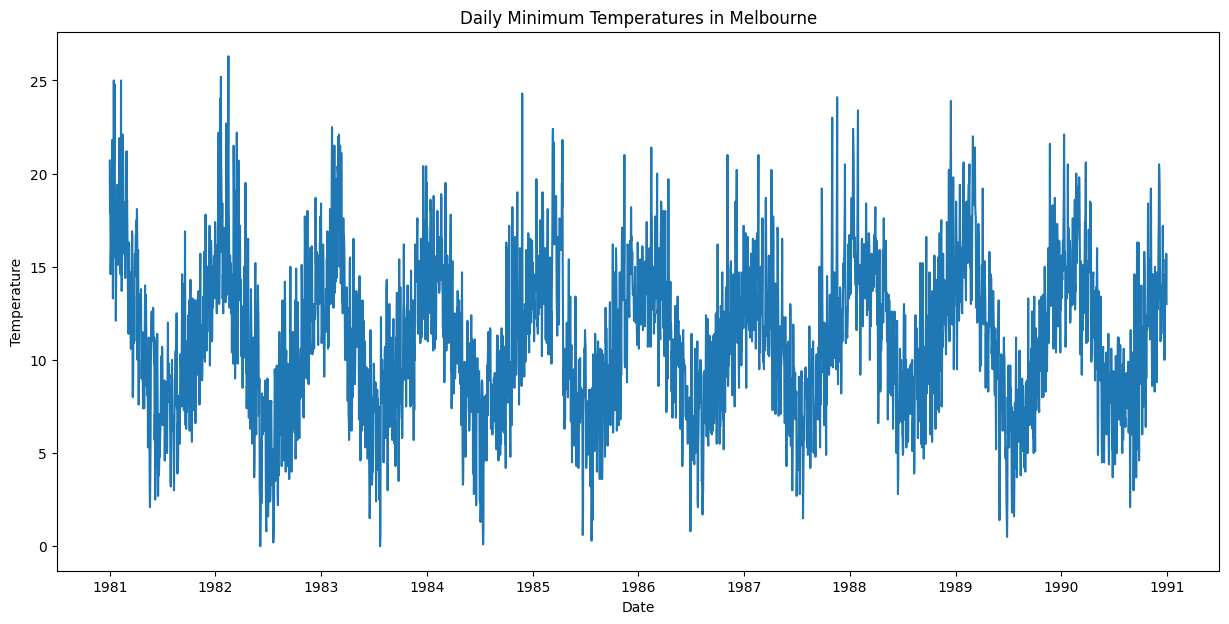

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import weight_norm
from urllib.parse import urljoin

data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"
df = pd.read_csv(urljoin(data_repo_url, "melbourne_temperature.csv"), header=0, parse_dates=['Date'], index_col='Date')

print("--- 원본 데이터 (처음 5개) ---")
print(df.head())

# 원본 데이터 시각화
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Temp'])
plt.title('Daily Minimum Temperatures in Melbourne')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

### 2. 데이터 준비

원본 데이터를 지도학습 데이터셋(슬라이딩 윈도우)으로 변환하고 훈련/테스트 세트로 분할합니다. 스케일링은 각 모델 내부에서 동적으로 처리합니다.

In [9]:
temp_data = df['Temp'].values.astype('float32').reshape(-1, 1)

# 결측치 확인 및 처리 (만약 있다면)
if np.isnan(temp_data).any():
    print("결측치를 ffill로 처리합니다.")
    temp_df = pd.DataFrame(temp_data)
    temp_df.fillna(method='ffill', inplace=True)
    temp_data = temp_df.values
    
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        dataX.append(data[i:(i + look_back), 0])
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 30 # 30일치 데이터를 보고 다음 날을 예측
X, y = create_dataset(temp_data, look_back)

# 시간 순서에 따라 데이터 분할 (마지막 1년을 테스트 데이터로 사용)
train_size = len(X) - 365
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = y[0:train_size], y[train_size:len(y)]

# PyTorch 텐서로 변환
trainX = torch.from_numpy(trainX).float()
trainY = torch.from_numpy(trainY).float()
testX = torch.from_numpy(testX).float()
testY = torch.from_numpy(testY).float()

print("--- 데이터셋 형태 ---")
print(f"trainX shape: {trainX.shape}, trainY shape: {trainY.shape}")
print(f"testX shape: {testX.shape}, testY shape: {testY.shape}")

--- 데이터셋 형태 ---
trainX shape: torch.Size([3255, 30]), trainY shape: torch.Size([3255])
testX shape: torch.Size([365, 30]), testY shape: torch.Size([365])


---

### 3. 모델 구현

#### 3.1 RNN & LSTM 모델
RNN과 LSTM을 모두 지원하는 `ScaledRecurrentModel` 클래스를 구현합니다. 모델 내부에서 동적 스케일링을 처리합니다.

In [10]:
class ScaledRecurrentModel(nn.Module):
    def __init__(self, model_type, input_size, hidden_size, output_size):
        super(ScaledRecurrentModel, self).__init__()
        if model_type not in ['RNN', 'LSTM']:
            raise ValueError("model_type must be 'RNN' or 'LSTM'")
        
        if model_type == 'RNN':
            self.recurrent_layer = nn.RNN(input_size, hidden_size, batch_first=True)
        else:
            self.recurrent_layer = nn.LSTM(input_size, hidden_size, batch_first=True)
            
        self.fc = nn.Linear(hidden_size, output_size)
        self.epsilon = 1e-8

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True) + self.epsilon
        x_scaled = (x.unsqueeze(-1) - mean.unsqueeze(-1)) / std.unsqueeze(-1)
        
        out_scaled, _ = self.recurrent_layer(x_scaled)
        out_scaled = self.fc(out_scaled[:, -1, :])
        
        out_unscaled = (out_scaled * std) + mean
        return out_unscaled.squeeze(-1)

#### 3.2 TCN (Temporal Convolutional Network) 모델
**TCN**은 합성곱(Convolution)을 기반으로 하는 시계열 모델입니다.

In [11]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# TCN의 기본 블록
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

# TCN 모델 전체
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        # TCN은 (배치, 채널, 시퀀스 길이) 형태를 입력으로 받음
        x = x.unsqueeze(1) # (배치, 1, 시퀀스 길이)로 변경
        y = self.network(x)
        # 마지막 타임스텝의 출력만 사용
        o = self.linear(y[:, :, -1])
        return o.squeeze(-1)

---

### 4. 모델 학습 및 평가

동일한 조건에서 세 모델을 학습시키고 예측 결과를 비교하기 위해, 학습과 평가 과정을 함수로 만듭니다.

In [27]:
def train_model(model, trainX, trainY, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model_name = model.__class__.__name__
    if isinstance(model, ScaledRecurrentModel):
        model_name = model.recurrent_layer.__class__.__name__
        
    print(f'--- {model_name} 모델 학습 시작 ---')
    for epoch in range(num_epochs):
        model.train()
        outputs = model(trainX)
        optimizer.zero_grad()
        loss = torch.sqrt(criterion(outputs, trainY)) # RMSE
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    print('--- 학습 완료 ---')
    return model

def evaluate_model(model, testX):
    model.eval()
    with torch.no_grad():
        predictions = model(testX).numpy()
    return predictions

In [28]:
# 모델 초기화
rnn_model = ScaledRecurrentModel('RNN', input_size=1, hidden_size=32, output_size=1)
lstm_model = ScaledRecurrentModel('LSTM', input_size=1, hidden_size=32, output_size=1)
tcn_model = TCN(input_size=1, output_size=1, num_channels=[16, 32, 64], kernel_size=3, dropout=0.2)

# 각 모델 학습
rnn_model = train_model(rnn_model, trainX, trainY)
lstm_model = train_model(lstm_model, trainX, trainY)
tcn_model = train_model(tcn_model, trainX, trainY)

# 각 모델 예측
rnn_preds = evaluate_model(rnn_model, testX)
lstm_preds = evaluate_model(lstm_model, testX)
tcn_preds = evaluate_model(tcn_model, testX)

--- RNN 모델 학습 시작 ---
Epoch [20/100], Loss: 2.7124
Epoch [40/100], Loss: 2.6107
Epoch [60/100], Loss: 2.5318
Epoch [80/100], Loss: 2.4715
Epoch [100/100], Loss: 2.4353
--- 학습 완료 ---
--- LSTM 모델 학습 시작 ---
Epoch [20/100], Loss: 2.7693
Epoch [40/100], Loss: 2.6800
Epoch [60/100], Loss: 2.5949
Epoch [80/100], Loss: 2.5147
Epoch [100/100], Loss: 2.4496
--- 학습 완료 ---
--- TCN 모델 학습 시작 ---
Epoch [20/100], Loss: 3.6836
Epoch [40/100], Loss: 2.8873
Epoch [60/100], Loss: 2.7674
Epoch [80/100], Loss: 2.6547
Epoch [100/100], Loss: 2.5995
--- 학습 완료 ---


---

### 5. 결과 비교 및 분석

세 모델의 예측 결과를 실제 데이터와 함께 시각화하여 성능을 비교합니다.

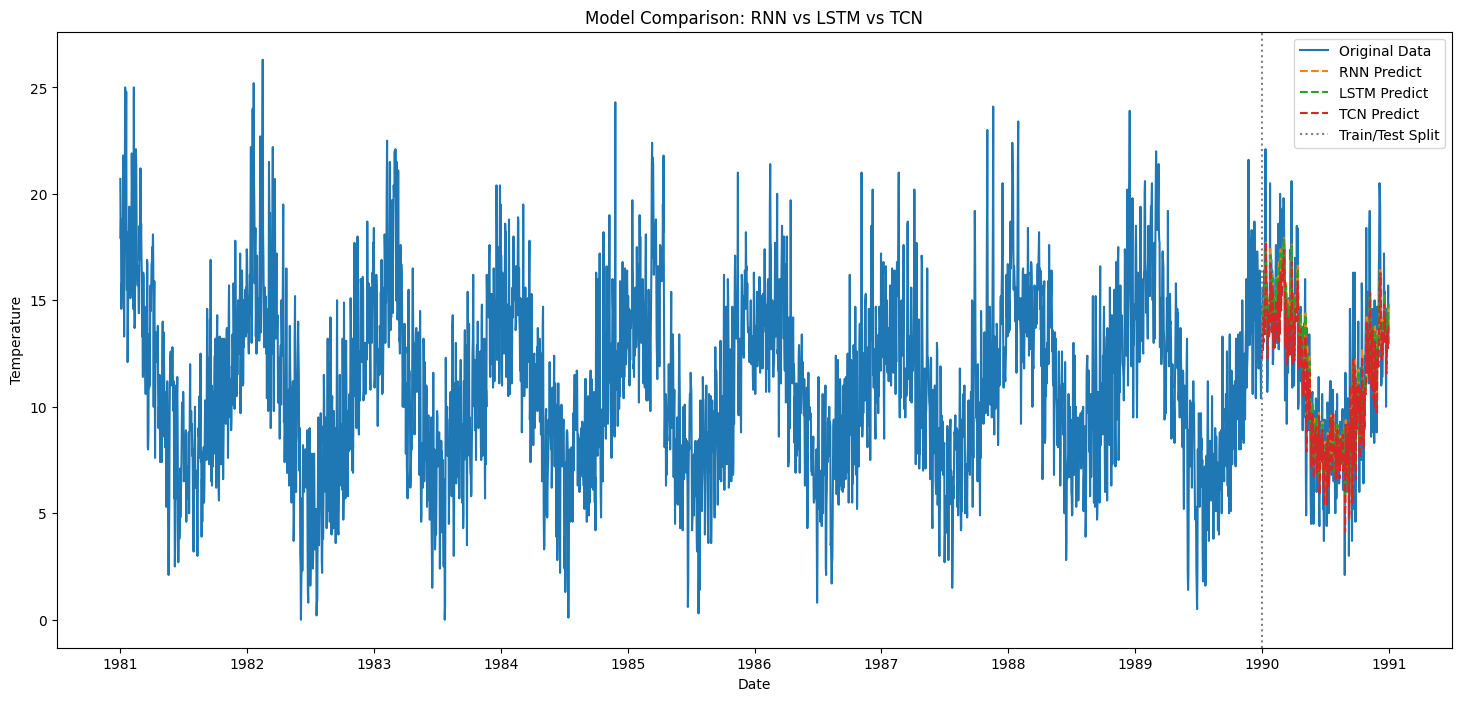

In [29]:
# 테스트 예측값을 위한 인덱스 계산
test_predict_index = df.index[train_size + look_back:]

# 결과 플롯
plt.figure(figsize=(18, 8))
plt.plot(df.index, df['Temp'], label='Original Data')
plt.plot(test_predict_index, rnn_preds, label='RNN Predict', linestyle='--')
plt.plot(test_predict_index, lstm_preds, label='LSTM Predict', linestyle='--')
plt.plot(test_predict_index, tcn_preds, label='TCN Predict', linestyle='--')
plt.axvline(x=df.index[train_size + look_back -1], c='gray', linestyle=':', label='Train/Test Split')

plt.title('Model Comparison: RNN vs LSTM vs TCN')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

RNN MAE: 1.7526
LSTM MAE: 1.7628
TCN MAE: 1.8286


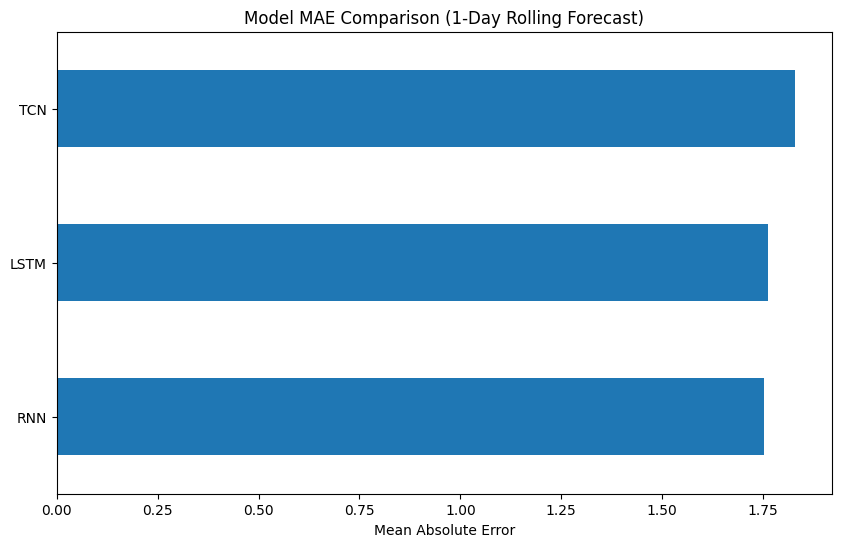

In [30]:
from sklearn.metrics import mean_absolute_error

mae_scores = {}
mae = mean_absolute_error(testY, rnn_preds)
mae_scores['RNN'] = mae
print(f'RNN MAE: {mae:.4f}')

mae = mean_absolute_error(testY, lstm_preds)
mae_scores['LSTM'] = mae
print(f'LSTM MAE: {mae:.4f}')

mae = mean_absolute_error(testY, tcn_preds)
mae_scores['TCN'] = mae
print(f'TCN MAE: {mae:.4f}')


# 성능 비교 시각화
plt.figure(figsize=(10, 6))
pd.Series(mae_scores).sort_values().plot(kind='barh')
plt.title('Model MAE Comparison (1-Day Rolling Forecast)')
plt.xlabel('Mean Absolute Error')
plt.show()